# Use k-Folds Cross Validator to Select a Model

* Portions of this notebook borrow code from :

Tatsat, Puri, Lookabaugh. *Machine Learning and Data Science Blueprints for Finance*. O'Reilly Media. 2020

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [2]:
%cd /content/gdrive/MyDrive/Github/ml-blog

/content/gdrive/MyDrive/Github/ml-blog


In [3]:
!pip install xlrd==1.2.0
!pip install matplotlib==3.5.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import xlrd


filename = 'default of credit card clients.xls'

DATA = os.path.relpath('/content/gdrive/MyDrive/Github/ml-blog/credit/data/' + filename)

df = pd.read_excel(DATA, 'Data', index_col=[0], header=[1], na_values='NA')
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [16]:
# Utility imports
from sklearn.model_selection import train_test_split, KFold

# Import Pipeline and Feature Transformers
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

# Import Estimators
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
# from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

# Import Evaluation Tools
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score


## Split the Data

In [6]:
X = df.copy()
y = X.pop('default payment next month')
X.info(), y

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 23 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   LIMIT_BAL  30000 non-null  int64
 1   SEX        30000 non-null  int64
 2   EDUCATION  30000 non-null  int64
 3   MARRIAGE   30000 non-null  int64
 4   AGE        30000 non-null  int64
 5   PAY_0      30000 non-null  int64
 6   PAY_2      30000 non-null  int64
 7   PAY_3      30000 non-null  int64
 8   PAY_4      30000 non-null  int64
 9   PAY_5      30000 non-null  int64
 10  PAY_6      30000 non-null  int64
 11  BILL_AMT1  30000 non-null  int64
 12  BILL_AMT2  30000 non-null  int64
 13  BILL_AMT3  30000 non-null  int64
 14  BILL_AMT4  30000 non-null  int64
 15  BILL_AMT5  30000 non-null  int64
 16  BILL_AMT6  30000 non-null  int64
 17  PAY_AMT1   30000 non-null  int64
 18  PAY_AMT2   30000 non-null  int64
 19  PAY_AMT3   30000 non-null  int64
 20  PAY_AMT4   30000 non-null  int64
 21  PAY_AMT5   3

(None, ID
 1        1
 2        1
 3        0
 4        0
 5        0
         ..
 29996    0
 29997    0
 29998    1
 29999    1
 30000    1
 Name: default payment next month, Length: 30000, dtype: int64)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Select Most Important Features with XGBoost

Feature: 0, Score: 0.01905
Feature: 1, Score: 0.01477
Feature: 2, Score: 0.01823
Feature: 3, Score: 0.01338
Feature: 4, Score: 0.01249
Feature: 5, Score: 0.41514
Feature: 6, Score: 0.18863
Feature: 7, Score: 0.03489
Feature: 8, Score: 0.03522
Feature: 9, Score: 0.02694
Feature: 10, Score: 0.03269
Feature: 11, Score: 0.01857
Feature: 12, Score: 0.01579
Feature: 13, Score: 0.01385
Feature: 14, Score: 0.01403
Feature: 15, Score: 0.01344
Feature: 16, Score: 0.01309
Feature: 17, Score: 0.01637
Feature: 18, Score: 0.01730
Feature: 19, Score: 0.02366
Feature: 20, Score: 0.01633
Feature: 21, Score: 0.01303
Feature: 22, Score: 0.01313


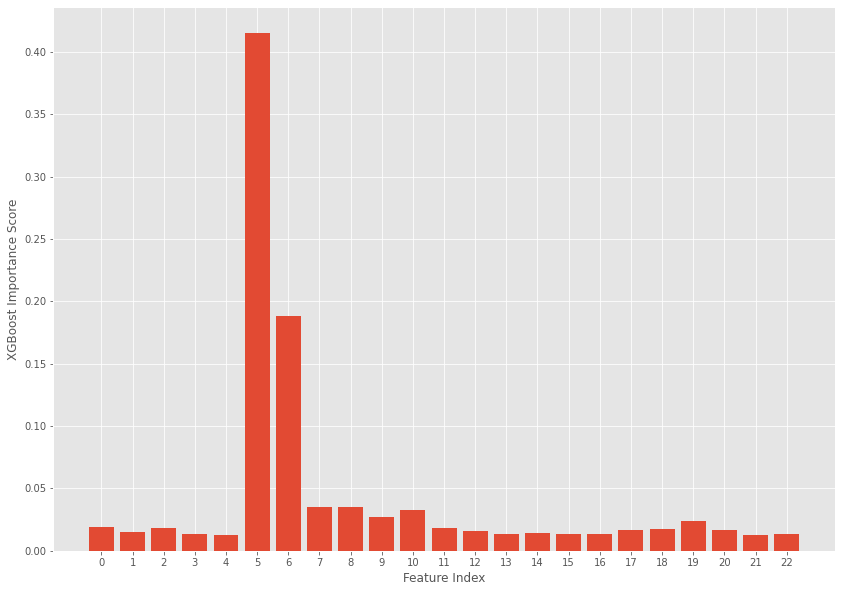

In [8]:
xgb_fs = XGBClassifier(n_estimators=50, max_depth=6, learning_rate=0.2)
xgb_fs.fit(X_train, y_train)
xgb_import = xgb_fs.feature_importances_

for i, v in enumerate(xgb_import):
    print("Feature: %0d, Score: %.5f" % (i, v))

plt.style.use('ggplot')
plt.figure(figsize=(14, 10))
plt.bar([x for x in range(len(xgb_import))], xgb_import)
plt.xticks(range(len(xgb_import)))
plt.xlabel('Feature Index')
plt.ylabel('XGBoost Importance Score')
plt.savefig('xgb_boost_importance_kfolds.png')
plt.show()

In [9]:
np.median(xgb_import), np.mean(xgb_import)

(0.016374458, 0.043478265)

In [10]:
choice_idx = np.where(xgb_import > np.median(xgb_import))

xgb_features_train = X_train.iloc[:, choice_idx[0]]
xgb_features_train.columns

Index(['LIMIT_BAL', 'EDUCATION', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5',
       'PAY_6', 'BILL_AMT1', 'PAY_AMT2', 'PAY_AMT3'],
      dtype='object')

## Standardize and One-Hot Encode Appropriate Features

In [11]:
cat_features = ['EDUCATION', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5',
                'PAY_6']

num_features = ['LIMIT_BAL', 'BILL_AMT1', 'PAY_AMT2', 'PAY_AMT3']

In [12]:
col_transform = ColumnTransformer(
    [('ohe', OneHotEncoder(handle_unknown='ignore'), cat_features),
    ('nums', StandardScaler(), num_features)],
    remainder='drop')

In [13]:
col_transform.fit(X_train)

ColumnTransformer(transformers=[('ohe', OneHotEncoder(handle_unknown='ignore'),
                                 ['EDUCATION', 'PAY_0', 'PAY_2', 'PAY_3',
                                  'PAY_4', 'PAY_5', 'PAY_6']),
                                ('nums', StandardScaler(),
                                 ['LIMIT_BAL', 'BILL_AMT1', 'PAY_AMT2',
                                  'PAY_AMT3'])])

In [70]:
col_transform.fit(X_test)

ColumnTransformer(transformers=[('ohe', OneHotEncoder(handle_unknown='ignore'),
                                 ['EDUCATION', 'PAY_0', 'PAY_2', 'PAY_3',
                                  'PAY_4', 'PAY_5', 'PAY_6']),
                                ('nums', StandardScaler(),
                                 ['BILL_AMT1', 'PAY_AMT2', 'PAY_AMT3'])])

In [14]:
col_transform.get_feature_names_out()

array(['ohe__EDUCATION_0', 'ohe__EDUCATION_1', 'ohe__EDUCATION_2',
       'ohe__EDUCATION_3', 'ohe__EDUCATION_4', 'ohe__EDUCATION_5',
       'ohe__EDUCATION_6', 'ohe__PAY_0_-2', 'ohe__PAY_0_-1',
       'ohe__PAY_0_0', 'ohe__PAY_0_1', 'ohe__PAY_0_2', 'ohe__PAY_0_3',
       'ohe__PAY_0_4', 'ohe__PAY_0_5', 'ohe__PAY_0_6', 'ohe__PAY_0_7',
       'ohe__PAY_0_8', 'ohe__PAY_2_-2', 'ohe__PAY_2_-1', 'ohe__PAY_2_0',
       'ohe__PAY_2_1', 'ohe__PAY_2_2', 'ohe__PAY_2_3', 'ohe__PAY_2_4',
       'ohe__PAY_2_5', 'ohe__PAY_2_6', 'ohe__PAY_2_7', 'ohe__PAY_2_8',
       'ohe__PAY_3_-2', 'ohe__PAY_3_-1', 'ohe__PAY_3_0', 'ohe__PAY_3_1',
       'ohe__PAY_3_2', 'ohe__PAY_3_3', 'ohe__PAY_3_4', 'ohe__PAY_3_5',
       'ohe__PAY_3_6', 'ohe__PAY_3_7', 'ohe__PAY_3_8', 'ohe__PAY_4_-2',
       'ohe__PAY_4_-1', 'ohe__PAY_4_0', 'ohe__PAY_4_1', 'ohe__PAY_4_2',
       'ohe__PAY_4_3', 'ohe__PAY_4_4', 'ohe__PAY_4_5', 'ohe__PAY_4_6',
       'ohe__PAY_4_7', 'ohe__PAY_4_8', 'ohe__PAY_5_-2', 'ohe__PAY_5_-1',
       'ohe__PAY

In [15]:
X_train_prep = pd.DataFrame(col_transform.transform(X_train).toarray(),
                            columns=col_transform.get_feature_names_out(), index=X_train.index)

X_test_prep = pd.DataFrame(col_transform.transform(X_test).toarray(),
                           columns=col_transform.get_feature_names_out(), index=X_test.index)

### Create List of Candidate Models

In [17]:
models = []
models.append(('LR', LogisticRegression(max_iter=300)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('SVC', SVC()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('XGB', XGBClassifier()))
models.append(('RF', RandomForestClassifier()))

### Evaluation Parameters

In [18]:
n_folds = 10
seed = 42

scoring = 'roc_auc'

### K-Fold Pipeline Definition

In [19]:
from time import time

In [20]:
results = []
names = []

for name, model in models:
    kfold = KFold(n_splits=n_folds, random_state=seed, shuffle=True)
    tic = time()
    cv_results = cross_val_score(model, X_train_prep, y_train, cv=kfold, scoring=scoring)
    toc = time()
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f) %3f %s" % (name, cv_results.mean(), cv_results.std(), toc-tic, 'ms')
    print(msg)


LR: 0.765643 (0.012161) 11.907263 ms
LDA: 0.763901 (0.012937) 3.590514 ms
SVC: 0.710340 (0.015758) 418.763065 ms
KNN: 0.711495 (0.012387) 11.413023 ms
CART: 0.625488 (0.010688) 2.790483 ms
NB: 0.737160 (0.011698) 0.392149 ms
XGB: 0.780772 (0.008313) 38.697271 ms
RF: 0.741418 (0.014751) 32.618635 ms


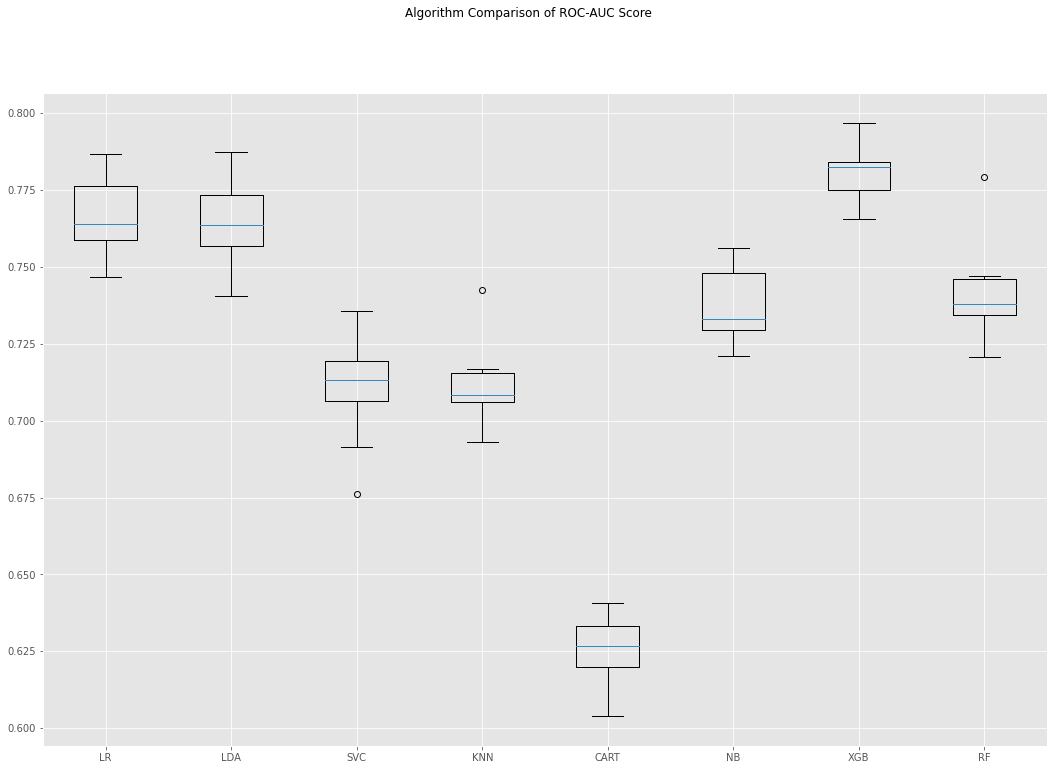

In [28]:
plt.style.use('ggplot')
fig = plt.figure()
fig.suptitle('Algorithm Comparison of ROC-AUC Score')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(18,12)
plt.savefig('kfold-compare-models-box.png')
plt.show()

* It looks like `XGBClassifier` has the most promising score.
* It would be a good idea to construct a **Neural Network** solutions to compare with this.